In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [2]:
figure_name = 'figures/FOOBAR_'

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 10.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400


drawing_size = 25


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'
mpl.rcParams['font.family'] =  ['DejaVu Sans']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'

# print(mpl.rcParams.keys())


In [7]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 16.0 # -> 40ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/20.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 3.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/4.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0
############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0

In [18]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax1):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.viridis,
        shade=True,
        linewidth=20)

    return ax1




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) # * 1/( gaba_exc+1.0) 
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(gaba_inh+1.0)       
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q



# Input

In [19]:

# GABA parameter
gaba_inh = np.linspace(0.0,1,30)
gaba_exc = np.linspace(0.0,1,30)

# to simulate that the gaba influence on the inhibitory side is stronger
# gaba_exc = gaba_inh * 0.7
# gabas = [(i,j) for i in gaba_exc[::-1] for j in gaba_inh]
# ratios = np.linspace(0,2,2)

# store values for different parameters
q_all = np.zeros((len(gaba_inh),len(gaba_exc),len(t),freq_bands))
r_all = np.zeros((len(gaba_inh),len(gaba_exc),len(t),freq_bands))

############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
for k in range(len(gaba_inh)):
    for l in range(len(gaba_exc)):
    
        ############################################################
        #                       Inputs                             #
        ############################################################
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))

        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        # Define input signal in a plausible way (gaussian input signal over frequency bands?)
        sigma = 1.0

        ### MNTB inhibitory input (contra-lateral) ###
        gbc_center_frequencyBand =2
        gbc_input_strength = 1.0

        # build ramps
        time_window = 400 # that equals a step of 5dB
        for i in range(0,len(t)-time_window,time_window):
            s_gbc_all[i:i+time_window,gbc_center_frequencyBand] = (i)/(len(t)-time_window) * gbc_input_strength


        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')


        # LSO direct excitatory input (ipsi-lateral)
        sbc_center_frequencyBand = 2
        sbc_input_strength = 1.0

        # build ramps
        for i in range(0,len(t)-time_window,time_window):
            s_sbc_all[i:i+time_window,sbc_center_frequencyBand] = (len(t)-time_window-i)/(len(t)-time_window) * sbc_input_strength


        # create a linearly decreasing function in frequency band 'center_frequencyband'
        # and smear it with a gauss to effect the neighboring bands
        sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')


        # Convolve with gauss curve to build a temporal ramp
        gauss_mask = gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1)
        s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='constant')
        gauss_mask = gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1)
        s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='constant')



        # correct for border effect of convolve
        s_gbc_all[-130:,gbc_center_frequencyBand] = np.max(s_gbc_all[-130:])
        s_sbc_all[:130,sbc_center_frequencyBand] = np.max(s_sbc_all[:130])



        for i in range(0, len(t)-1):
                for w in range(0,freq_bands):
                    # E-E kernel
                    ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                    ei_kernel = gauss(np.arange(freq_bands),w,0.6)
                    ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                    ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                    # normalize it 
                    ee_kernel /= np.max(ee_kernel)
                    ei_kernel /= np.max(ie_kernel)
                    ie_kernel /= np.max(ie_kernel)
                    ii_kernel /= np.max(ie_kernel)

                    delay_factor = 20
                    # as an MNTB input we use the value of the previously calculated time step. 
                    # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                    if i < delay_factor:
                        r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,gaba_exc[l],gaba_inh[k])       
                    else:
                        r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,gaba_exc[l],gaba_inh[k])             

                    q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)





KeyboardInterrupt: 

In [ ]:
# Define the times when to probe
probing_times = [1750]
probing_times = np.arange(300,len(t),time_window)

# show LSO neuron membrane
# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
fig = plt.figure(figsize=(12,6))
ax2 = fig.add_subplot(111)
for j in range(0,r.shape[0]):
    if j == 0:
        line_style = '-'
    elif j == 1:
        line_style = '--'
    else:
        line_style = ':'

    for i in range(0,r.shape[1]):
        plt.plot(r[j,i,:],linestyle=line_style)
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('LSO Neuron Membrane')
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.ylim([-1.0,1])
plt.show()

In [ ]:
# Define the times when to probe
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]

fig = plt.figure(figsize=(12,6))

## show LSO neuron response
ax2 = fig.add_subplot(111)
for i in range(0,r.shape[0]):
    for j in range(0,r.shape[1]):
        tmp = g_r_out(r[i,j,probing_times])
        # normalize it
    #     tmp = tmp -  np.min(tmp)
    #     tmp = tmp / np.max(tmp)
        ax2.plot(diff_input[probing_times],tmp,linestyle='-')
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Response for Varying GABA Values')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
ax2.set_xticklabels(ax2.get_xticks()*100)

lgd = plt.legend()

plt.show()




In [11]:
# %matplotlib notebook

In [12]:
# fig = plt.figure(figsize=(10,10))

# ## show LSO neuron response
# ax2 = fig.add_subplot(111,projection='3d')
# # ind = np.ravel_multi_index([list(range(0,25)),list(range(0,25))],(25,25))
# # tmp = np.reshape(g_r_out(r[:,:,probing_times]),(len(ratios)**2,20))
# # ind = ind[0:-5]
# # t1 = ind[::5]
# # t2 = ind[1::5]
# # t3 = ind[2::5]
# # t4 = ind[3::5]
# # t5 = ind[4::5]
# # ind = np.concatenate((t1,t2,t3,t4,t5))
# # # t1 = ind[::5]
# # # t2 = ind[1::5]
# # # t3 = ind[2::5]
# # # t4 = ind[3::5]
# # # t5 = ind[4::5]
# # # ind = np.concatenate((t1,t2,t5,t4[::-1],t3))

# # tmp = tmp[ind]
# # print(tmp.shape)


# # ax2 = mesh_plot(np.squeeze(g_r_out(r[:,:,5000])),ax2)
# ax2.plot(gaba_exc,gaba_inh,np.squeeze(g_r_out(r[:,0,5000])))
# plt.show()

In [13]:
# # Define the times when to probe
# probing_times = np.arange(300,len(t),time_window)

# fig = plt.figure(figsize=(12,6))

# ## show LSO neuron response
# ax2 = fig.add_subplot(111)
# tmp = g_r_out(r[0,0,probing_times])
# ax2.plot(diff_input[probing_times],tmp,linestyle='-',label='GABA_exc = {0:.2f}, GABA_inh = {1:.2f}'.format(gaba_exc[0],gaba_inh[0]))

# tmp2 = g_r_out(r[-1,-1,probing_times])
# ax2.plot(diff_input[probing_times],tmp2,linestyle='-',color='#6baed6',label='GABA_exc = {0:.2f}, GABA_inh = {1:.2f}'.format(gaba_exc[-1],gaba_inh[-1]))

# ax2.fill_between(diff_input[probing_times],tmp, tmp2, facecolor='#9ecae1', alpha=0.7,label='Adaptation Range')

# # plt.axvline(x=0.0,linestyle='--',color='grey')
# # plt.axhline(y=0.5,linestyle='--',color='grey')
# ax2.invert_xaxis()
# plt.title('LSO Neuron Response for Stronger Inhibition on GABA_inh')
# plt.xlabel('ILD [dB]')
# plt.ylabel('Response Rate [au]')
# ax2.set_xticklabels(ax2.get_xticks()*100)

# lgd = plt.legend()


# plt.show()




In [14]:
# fig = plt.figure(figsize=(6,6))

# a = g_r_out(r[2,:,:])
# b = q[2,:,:]

# plt.plot(b.T,a.T)
# plt.show()





In [15]:
# %matplotlib inline

0.527272727272727


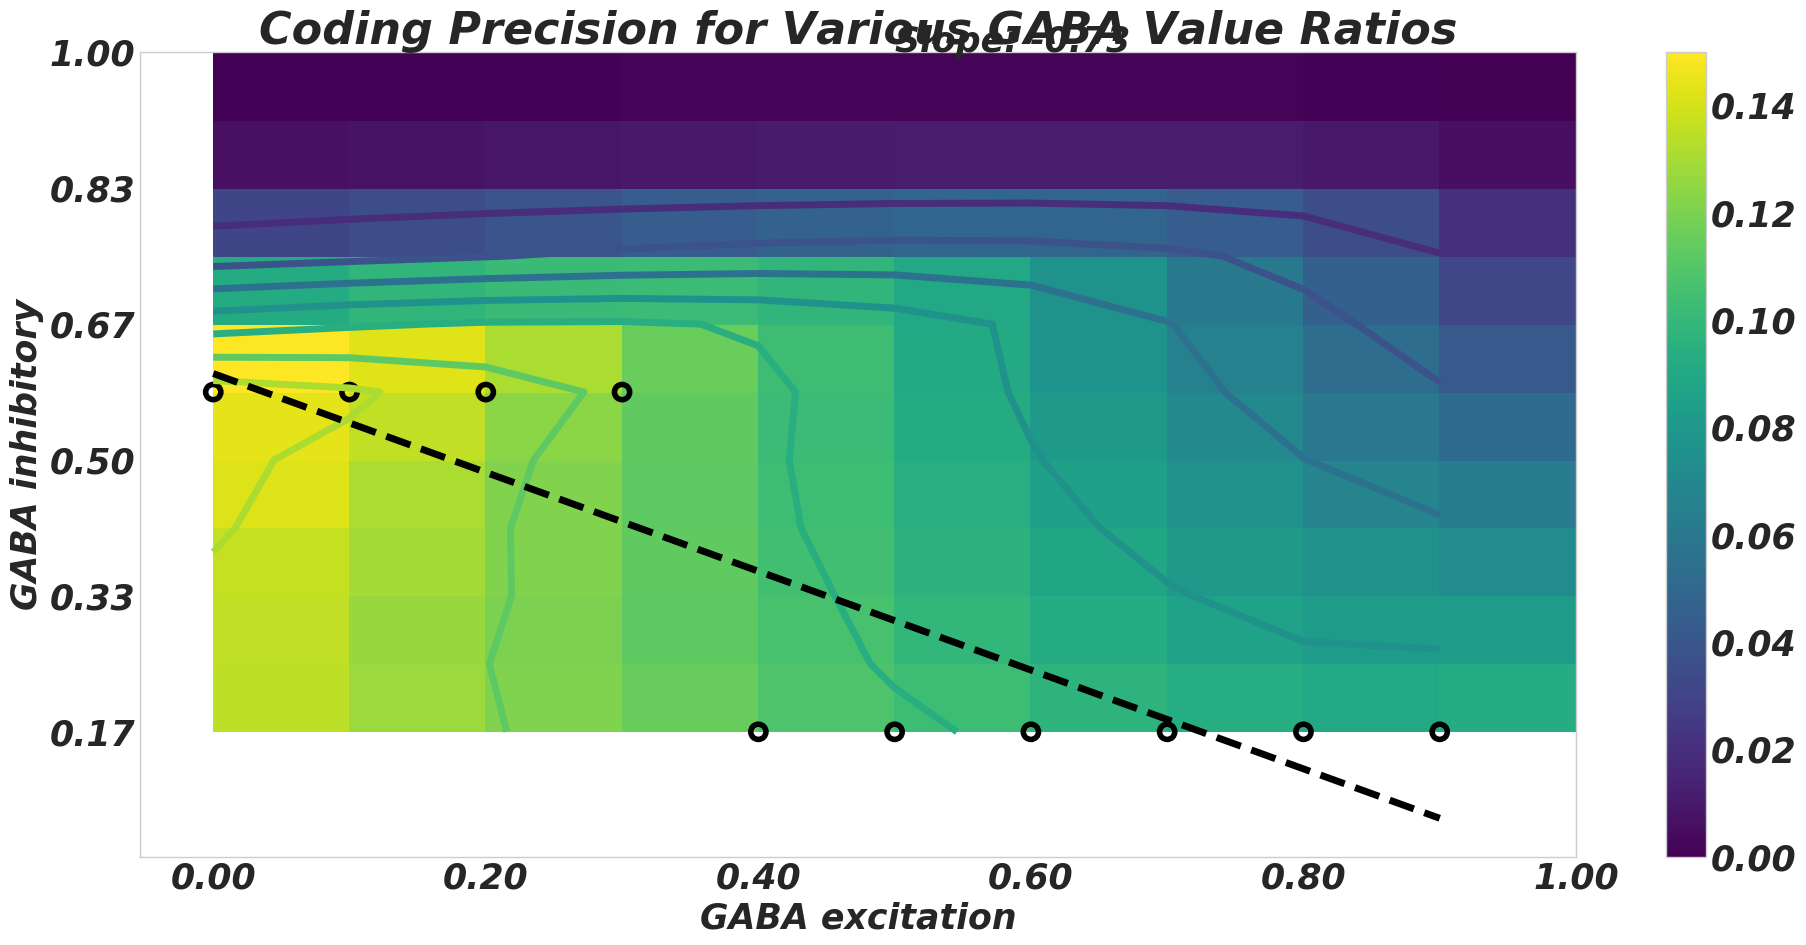

In [23]:
fig = plt.figure()
# ax2 = fig.add_subplot(111,projection='3d')
ax2 = fig.add_subplot(111)

## show LSO neuron response
probing_times = np.arange(1900,len(t)-1900,time_window)
# probing_times = 5000
tmp = -np.array(np.gradient(g_r_out(r[:,:,probing_times]),axis = 2))

# maxi_arg = np.squeeze(np.argmax(tmp,axis=2))
maxi = np.squeeze(np.max(tmp,axis=2))
                     

c = ax2.pcolormesh(maxi[:,:],cmap='viridis')
ax2.contour(maxi,cmap='viridis')
data_peaks = np.zeros(maxi.shape[0]-0)
for i in range(maxi.shape[0]-0):
    data_peaks[i] = np.argmax(maxi[:,i])
    ax2.scatter(i,np.argmax(maxi[:,i]),s=120,linewidth=4,color= 'black',facecolors='none')

# calculate linear regression function for peak points (walk on the ridghe of the hill)
fit = np.polyfit(range(data_peaks.shape[0]),data_peaks,1)
fit_fn = np.poly1d(fit) 
print(fit_fn[0]/10)
ax2.plot(fit_fn(range(maxi.shape[0])),color= 'black', linestyle = '--')

ax2.annotate("Slope: {0:0.2f}".format(fit_fn[1]), xy=(maxi.shape[0]/2, 10), xytext=(maxi.shape[0]/2, 10))

# ax2.hlines(30*0.38,0,30)

plt.colorbar(c)

ax2.set_title('Coding Precision for Various GABA Value Ratios')
ax2.set_xlabel('GABA excitation')
ax2.set_ylabel('GABA inhibitory')

ax2.set_yticklabels(['{0:.2f}'.format(k) for k in np.linspace(0,1,len(ax2.get_yticks()))])
ax2.set_xticklabels(['{0:.2f}'.format(k/maxi.shape[0]) for k in ax2.get_xticks()])
plt.tight_layout()

# plt.savefig(figure_name + 'plot.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(figure_name + 'plot.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')


plt.show()

### Here we can now draw a diagonal to show the ratio of gaba values so that we have a most effective GABA receptor ratio.

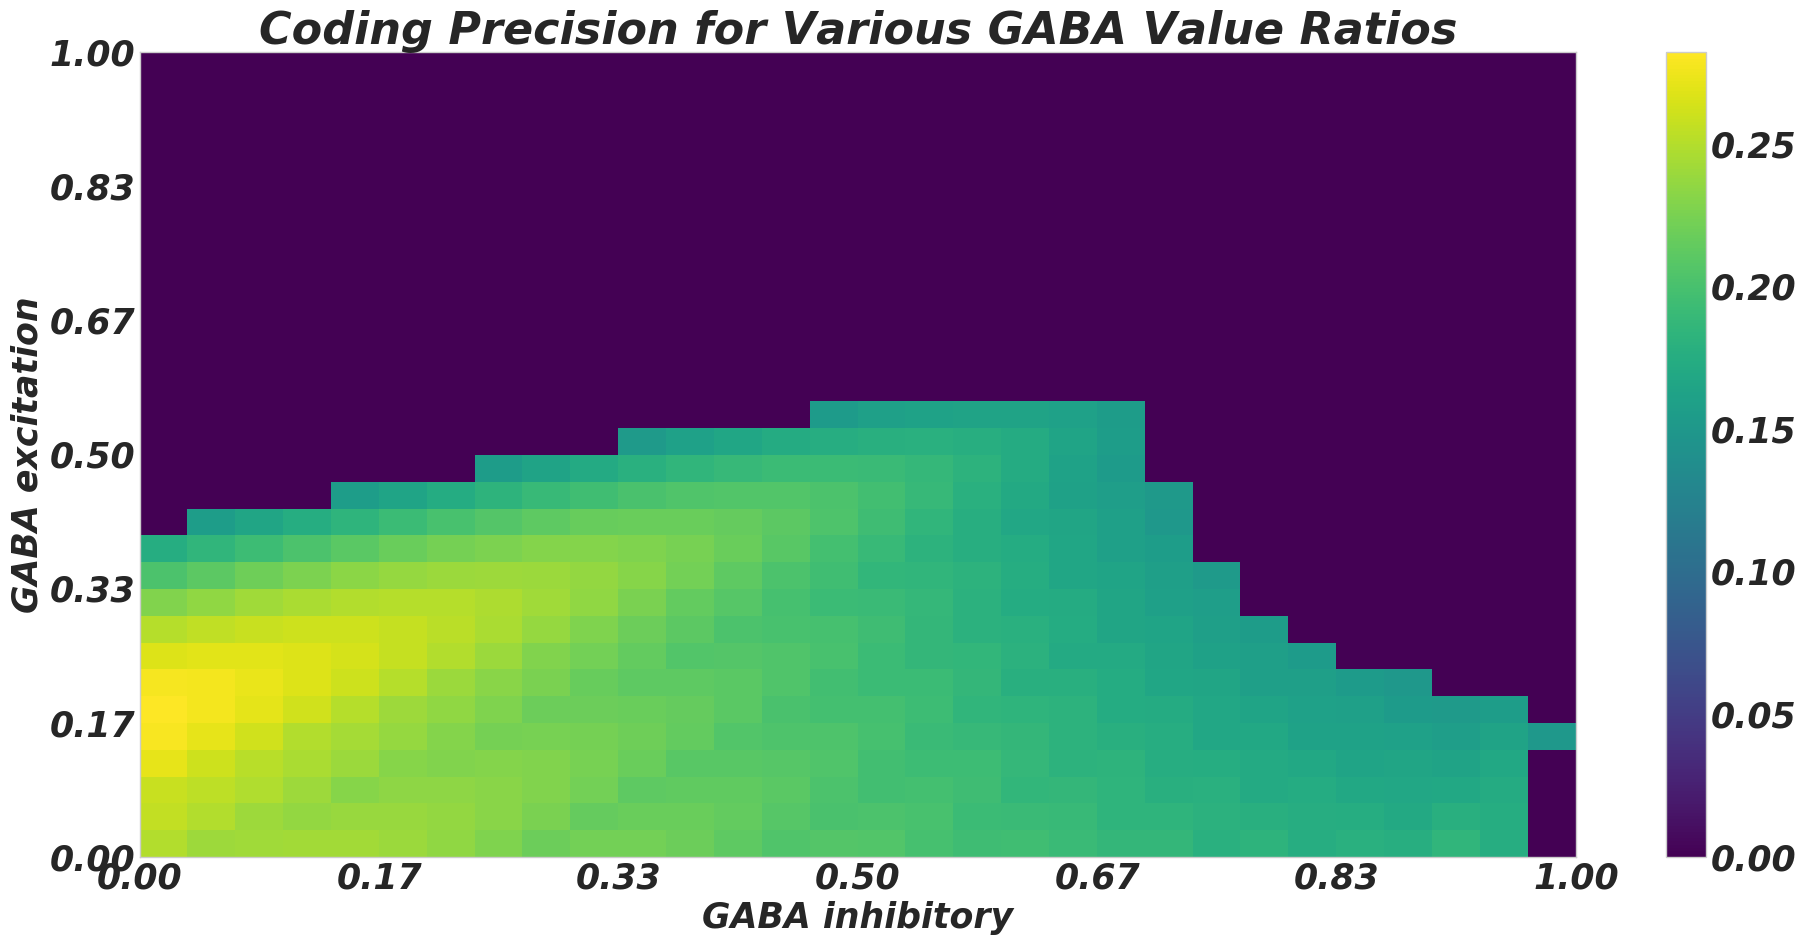

In [237]:
fig = plt.figure()
# ax2 = fig.add_subplot(111,projection='3d')
ax2 = fig.add_subplot(111)

## show LSO neuron response
probing_times = np.arange(1900,len(t)-1900,time_window)
# probing_times = 5000
tmp = -np.array(np.gradient(g_r_out(r[:,:,probing_times]),axis = 2))

# maxi_arg = np.squeeze(np.argmax(tmp,axis=2))
maxi = np.squeeze(np.max(tmp,axis=2))
                     

c = ax2.pcolormesh(np.where(maxi>0.15,maxi,0),cmap='viridis')
plt.colorbar(c)



ax2.set_title('Coding Precision for Various GABA Value Ratios')
ax2.set_xlabel('GABA inhibitory')
ax2.set_ylabel('GABA excitation')

ax2.set_yticklabels(['{0:.2f}'.format(k) for k in np.linspace(0,1,len(ax2.get_yticks()))])
ax2.set_xticklabels(['{0:.2f}'.format(k) for k in np.linspace(0,1,len(ax2.get_xticks()))])
plt.tight_layout()

# plt.savefig(figure_name + 'plot.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(figure_name + 'plot.pdf', bbox_extra_artists=(lgd,),bbox_inches='tight')


plt.show()